In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

figures_path = os.path.join(os.getcwd(), "figures")

### Sample from the DGP

In [2]:
# Define the data generating process as per the example
def generate_data(n_samples, sigma_squared):
    """
    Generates data according to the structural equation model provided in the example.
    
    Parameters:
        n_samples (int): Number of samples to generate.
        sigma_squared (float): The variance of the noise for X1 and Y.
    
    Returns:
        X1 (np.array): Generated data for X1.
        X2 (np.array): Generated data for X2.
        Y (np.array): Generated data for Y.
    """
    # X1 <- Gaussian(0, sigma_squared)
    X1 = np.random.normal(0, np.sqrt(sigma_squared), n_samples)
    
    # Y <- X1 + Gaussian(0, sigma_squared)
    Y = X1 + np.random.normal(0, np.sqrt(sigma_squared), n_samples)
    
    # X2 <- Y + Gaussian(0, 1)
    X2 = Y + np.random.normal(0, 1, n_samples)
    
    return X1, X2, Y

In [3]:
# Set the number of samples to generate
n_samples = 1000

# Generate the data for environment 1
X1_1, X2_1, Y_1 = generate_data(n_samples, sigma_squared=10)

# Generate the data for environment 2
X1_2, X2_2, Y_2 = generate_data(n_samples, sigma_squared=20)

# concatenate all data
X1 = np.concatenate((X1_1, X1_2))
X2 = np.concatenate((X2_1, X2_2))

Y = np.concatenate((Y_1, Y_2))
X = np.vstack((X1, X2)).T

X1 = np.expand_dims(X1, axis=1)
X2 = np.expand_dims(X2, axis=1)

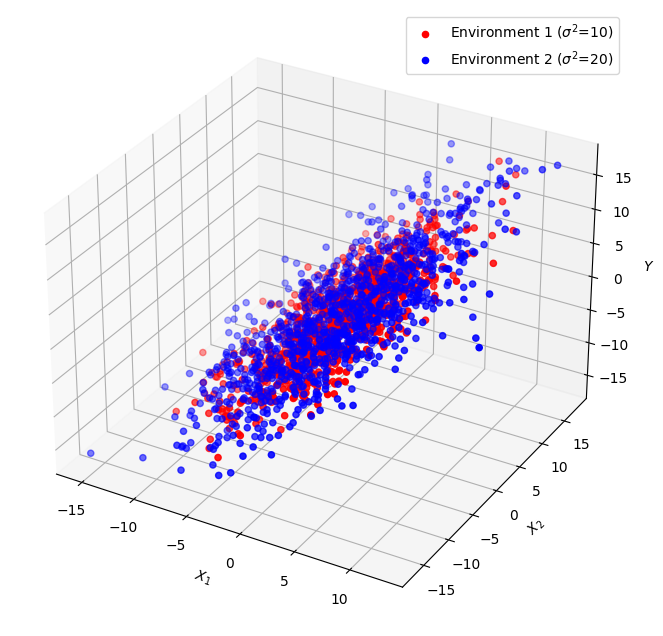

In [5]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the generated data
ax.scatter(X1_1, X2_1, Y_1, c='r', marker='o', label=r'Environment 1 ($\sigma^2$=10)')
ax.scatter(X1_2, X2_2, Y_2, c='b', marker='o', label=r'Environment 2 ($\sigma^2$=20)')

ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_zlabel(r'$Y$')
# ax.set_title('Relationship of Y on X1 and X2 in each environment')
ax.legend()

# export the plot
plt.savefig(os.path.join(figures_path, 'y_x1_x2_3d.png'))
plt.show()

## Plot naive discrepancy measure $D_{\text{dist}}$

In [131]:
# define the non-linear transformation function Phi
def Phi(X, c):
    # create a diagonal matrix with [1, c] on the diagonal
    diag_c = np.array([[1, 0], [0, c]])
    
    return X @ diag_c

# define the OLS regression function
def ols_regression(X, Y):
    # using the Normal Equation to compute the least squares solution
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ Y
    
    return beta_hat

# define the discrepancy measure D_dist
def D_dist(w, w_phi):
    # calculate the discrepancy as the squared norm of the difference between w and w_phi_e
    return np.linalg.norm(w - w_phi)**2

def D_lin(w, Phi, Y):
    # compute the expected value of the outer product of Phi
    E_Phi_Phi_T = np.mean(Phi[:, :, np.newaxis] * Phi[:, np.newaxis, :], axis=0)
    
    # compute the expected value of the product of Phi and Y
    E_Phi_Y = np.mean(Phi * Y[:, np.newaxis], axis=0)
    
    # calculate the discrepancy measure
    return np.linalg.norm(E_Phi_Phi_T @ w - E_Phi_Y) ** 2


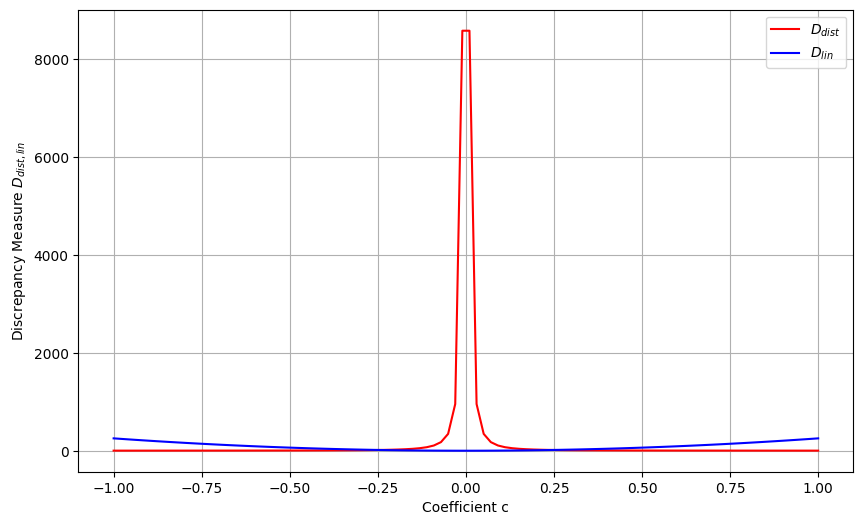

In [145]:
c_values = np.linspace(-1, 1, 100)
w = np.array([1, 0], dtype=np.float64)

# recalculate the D_dist values using the fixed functions
D_dist_values = []
D_lin_values = []
for c in c_values:
    # apply the non-linear transformation Phi to X
    Phi_X = Phi(X, c)
    
    # compute the OLS regression for the transformed Phi_X and Y
    w_phi = ols_regression(Phi_X, Y)
    
    # calculate the discrepancy D's
    D_dist_value = D_dist(w, w_phi)
    D_lin_value = D_lin(w, Phi_X, Y)
    D_dist_values.append(D_dist_value)
    D_lin_values.append(D_lin_value)

# plot the discrepancy measure D_dist
plt.figure(figsize=(10, 6))
plt.plot(c_values, D_dist_values, label=r'$D_{dist}$', color='r')
plt.plot(c_values, D_lin_values, label=r'$D_{lin}$', color='b')
plt.xlabel('Coefficient c')
plt.ylabel(r'Discrepancy Measure $D_{dist, lin}$')
# plt.title('Discrepancy Measures by varying coefficient c')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(figures_path, 'discrepancy_measures.png'))
plt.show()